In [169]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [88]:
class LinedSheet:
    def __init__(self, spacing: int|float, space_number: int, height: int|float, needle_length: None|float = None):
        # Sheet attributes
        self.spacing = spacing
        self.length = spacing * space_number # sheet length will always be a multiple of "spacing" attribute
        self.height = height
        # Needles attributes
        self.needle_length = needle_length if needle_length is not None else spacing
        self.needles_positions: None|list[tuple] = None
        self.crossings = None

    def throw_needle(self) -> list[tuple]:
        x1_needle, y1_needle = np.random.uniform(0, self.length), np.random.uniform(0, self.height) # coordinates of one end
        alpha_needle = np.random.uniform(0, np.pi/2) # orientation of the thrown needle with respect to the sheet
        # Calculating the coordinates of the other end
        x2_needle = x1_needle + self.needle_length*np.cos(alpha_needle)
        y2_needle = y1_needle + self.needle_length*np.sin(alpha_needle)
        # Handle invalids throws
        if (x2_needle < 0 or x2_needle > self.length) or (y2_needle < 0 or y2_needle > self.height):
            self.throw_needle()
        self.needles_positions = [((x1_needle, y1_needle), (x2_needle, y2_needle))]
        return self.needles_positions
    
    def throw_needles(self, throws_number: int) -> list[tuple]:
        needles_coords = []
        for _ in range(throws_number):
            needle_coords = self.throw_needle()
            needles_coords.extend(needle_coords)
        self.needles_positions = needles_coords
        return self.needles_positions
    
    def count_crossings(self) -> int:
        crossing_count = 0
        if self.needles_positions is None:
            raise ValueError(f"Attribute {self.needles_positions = }. Call {self.throw_needles.__name__} or {self.throw_needle.__name__} before execute {self.count_crossings.__name__}")
        for pos in self.needles_positions:
            end_one, end_two = pos
            xs = (end_one[0], end_two[0])
            #ys = (end_one[1], end_two[1])
            min_x, max_x = xs if xs[0] <= xs[1] else xs[::-1]
            for _ in np.arange(self.spacing, self.length, self.spacing):
                if min_x <= _ <= max_x:
                    crossing_count += 1
        self.crossings = crossing_count
        return self.crossings
    
    def calc_result(self) -> dict:
        throws = self.needles_positions
        result = {
            "crossings": self.count_crossings(),
            "total_throws": len(throws),
            "needle_length": self.needle_length,
            "line_spacing": self.spacing, 
        }
        # Calculate probability and estimate pi
        result["probability"] = result["crossings"]/result["total_throws"]
        result["estimated_pi"] = (2*result["needle_length"])/(result["probability"]*result["line_spacing"])
        return result
        
    def display_needles(self):
        if self.needles_positions is None:
            raise ValueError(f"Attribute {self.needles_positions = }. Call {self.throw_needles.__name__} or {self.throw_needle.__name__} before execute {self.count_crossings.__name__}")
        needles_coords = self.needles_positions
        # Display the thrown needle
        fig = figure(figsize=(20, 10)) 
        ax = fig.add_subplot(111)
        ax.set_title("Needles throws")
        ax.set_xlim(0, self.length)
        ax.set_ylim(0, self.height)
        ax.vlines(x = np.arange(self.spacing, self.length, self.spacing), 
                                ymin= 0,
                                ymax = self.height,
                                linestyles= "dashed",
                                colors="g",
                                )   
        for needle_coord in needles_coords:
            end_one, end_two = needle_coord
            xs = (end_one[0], end_two[0])
            ys = (end_one[1], end_two[1])
            ax.plot(xs, ys, linestyle = "solid", linewidth = 3, color = '#acbacb',
                    marker = "8", markerfacecolor = "#acbacb", markeredgecolor = "#acbacb") # marker settings    
        plt.show()

In [ ]:
pi_sheet = LinedSheet(spacing=5, space_number=200, height=20)
pi_sheet.throw_needles(throws_number=100_000)
print(pi_sheet.calc_result())

{'crossings': 63311, 'total_throws': 100000, 'needle_length': 5, 'line_spacing': 5, 'probability': 0.63311, 'estimated_pi': 3.1590087030689773}


In [ ]:
def confidence_interval_calc(sheet:LinedSheet = pi_sheet, n_samples: int = 30, sample_dim: int = 30, throws_mumber: int = 100_000) -> tuple[float,tuple, np.ndarray]:
    sheet = sheet
    samples_means = [] # Initialize an empty list to collect the samples means
    for n in range(n_samples):
        sample_mean = 0
        for _ in range(sample_dim):
            sheet.throw_needles(throws_number = throws_mumber)
            result = sheet.calc_result()
            sample_mean += result["estimated_pi"]
        sample_mean /= sample_dim
        samples_means.append(sample_mean)
    
    samples_means = np.asarray(samples_means)
    # Compute estimators
    means_mean = samples_means.mean()
    stdev = np.std(a = samples_means, ddof = 1, mean = means_mean) # estimate the standard deviation for the samples means
    stdev /= np.sqrt(len(samples_means))
    # Calculate confidence range
    confidence_interval = (means_mean - 1.96*stdev, means_mean + 1.96*stdev)
    print(f"Confidence interval at 95%: {confidence_interval[0]}, {confidence_interval[1]}")
    print(f"Estimated pi: {means_mean}")

    return means_mean, confidence_interval, samples_means

def plot_means(samples_means: np.ndarray, save_fig: bool = False, figsize: tuple = (8,5)):
    fig = figure(figsize = figsize)
    ax = fig.add_subplot(111)
    ax.grid(visible = True, axis = "y", c = "grey", ls = "--", alpha = 0.8)
    ax.set_axisbelow(b = False)
    sns.histplot(x = samples_means, bins = "auto", kde = True, ax=ax)
    ax.set_title("Sample means distribution")
    ax.set_ylabel("")
    ax.set_xlabel(r"Means of estimated $\pi$")
    plt.show()
    if save_fig:
        fig.savefig(fname = "means_distribution.png", format = "png")

Confidence interval at 95%: 3.174234497267321, 3.20553303906891
Estimated pi: 3.1898837681681154


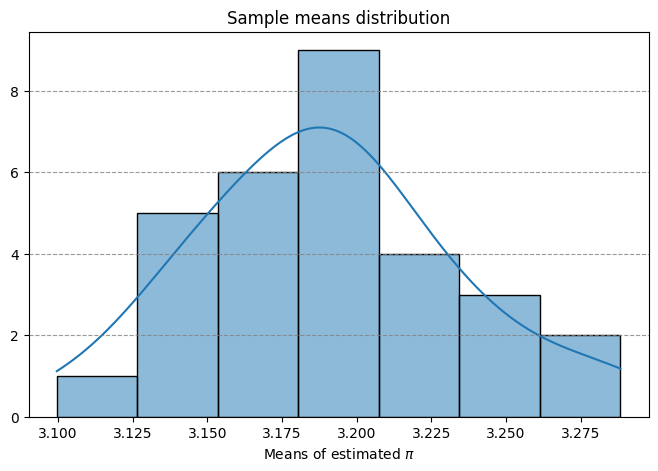

In [ ]:
stats = confidence_interval_calc(throws_mumber= 100)
plot_means(samples_means=stats[2])

## How the angle affects probability

Let's suppose that:
1. the sheet is put within a metal coil that produce a magnetic field;
2. the needles are made of iron.

We'll expect that they will dispose in such a way to follow the field lines of the applied magnetic field.
Hence their orientation with respect to the paper won't be random anymore.

Let's create a new class that take in account the new distribution feature.

In [90]:
class OrientedLinedSheet(LinedSheet):
    def __init__(self, spacing: int|float, space_number: int, height: int|float, needle_length: None|float = None, angle: float = np.pi/4, angle_dispersion: float = np.pi*0.02):
        super().__init__(spacing, space_number, height, needle_length)
        self.theta = angle  # This angle represents the orientation of the magnetic field with respect to sheet lines
        self.angle_dispersion = angle_dispersion
        
    def throw_needle(self) -> list[tuple]:
        x1_needle, y1_needle = np.random.uniform(0, self.length), np.random.uniform(0, self.height) # coordinates of one end
        # The angle used for generating random needles coordinates is NOT the orientation angle, but it is linked to the latter by the following equation:
        alpha = np.pi/2 - self.theta
        angle_range = (alpha - self.angle_dispersion, alpha + self.angle_dispersion) # adding some noise in orientation
        alpha_needle = np.random.uniform(*angle_range) # orientation of the thrown needle with respect to the sheet
        # Calculating the coordinates of the other end
        x2_needle = x1_needle + self.needle_length*np.cos(alpha_needle)
        y2_needle = y1_needle + self.needle_length*np.sin(alpha_needle)
        # Handle invalids throws
        if (x2_needle < 0 or x2_needle > self.length) or (y2_needle < 0 or y2_needle > self.height):
            self.throw_needle()
        self.needles_positions = [((x1_needle, y1_needle), (x2_needle, y2_needle))]
        return self.needles_positions

    def calc_result(self) -> dict:
        throws = self.needles_positions
        result = {
            "crossings": self.count_crossings(),
            "total_throws": len(throws),
            "needle_length": self.needle_length,
            "line_spacing": self.spacing, 
        }
        # Calculate probability
        result["probability"] = result["crossings"]/result["total_throws"]
        return result

Let's run four different simulations with four different orientations (angles) and see how probability change.

In [ ]:
for theta in (0, np.pi/4, np.pi/3, np.pi/2, 3/4*np.pi, np.pi): # Run simulations for 0°, 45°, 60°, 90°
    oriented_sheet = OrientedLinedSheet(spacing=5, space_number=200, height=20, angle= theta)
    oriented_sheet.throw_needles(throws_number= 100_000)
    result_dict = oriented_sheet.calc_result()
    probability = result_dict["probability"]
    print(f"Probability (%) of needles crossing lines for angle {np.round(theta*360/(np.pi*2), 0)}: {np.round(probability*100, 2)}")


Probability (%) of needles crossing lines for angle 0.0: 3.12
Probability (%) of needles crossing lines for angle 45.0: 70.26
Probability (%) of needles crossing lines for angle 60.0: 86.11
Probability (%) of needles crossing lines for angle 90.0: 99.46
Probability (%) of needles crossing lines for angle 180.0: 3.07
Probability (%) of needles crossing lines for angle 135.0: 70.38


From the results above we can see that the probability increases while $ 0 \le \theta \le \frac{\pi}{2}$.  
After that, probability start to decrease.
Then, we could suppose that the probability is proportional to the sine of the angle:  
$ p \propto sin\theta$ 

### Breaking down the theory

How can we explain these results?  
How exactly the angle is affecting probability?  
Let's start from the theory of the original experiment.

### Original Buffon needles experiment
Let $x$ be the distance between the center of the needle and the line  
Let $\theta$ be the angle between the needle and the line  
Let $t$ be the distance among each pair of consecutive lines  

Probability density of x between 0 and t/2:  

$\frac{2}{t}\,dx$  

Probability density of angle between 0 and $\frac{\pi}{2}\,$:  

$\frac{2}{\pi}\,d\theta$

The total probability density is:  

$f(x, \theta)dxd\theta = \frac{4}{t\pi}\,dxd\theta$

The needles cross a line if this condition is met:  

$x \le \frac{\ell}{2}\,sin\theta$

Hence, the probability can be calculated as follows:  

$ p = \int _{0}^{\frac {\pi }{2}}\int _{0}^{(\ell /2)\sin \theta }{\frac {4}{t\pi }}\,dx\,d\theta ={\frac {2\ell }{t\pi }} $  


For $\ell = t$:  

$ p = \frac{2}{\pi}$

### Oriented needles version of Buffon experiment

In this case the probability density of x remains the same:  
$\frac{2}{t}\,dx \qquad \textrm{for}\quad 0\le x \le \frac{t}{2}.$

The angle $\theta$, anyway, will assume one value. Hence, we won't integrate over theta.
The total probability density will be:  
$f(x)dx = \frac{2}{t}\,dx$

Eventually, the probability will be calculated as follows:  
$ p = \int_{0}^{\frac{\ell}{2}\, sin\bar{\theta}}{\frac{2}{t}\,dx} = \frac{\ell}{t}\, sin\bar{\theta} \qquad \textrm{where } \bar{\theta} \textrm{ is a fixed values.}$

Recalling that $\ell = t$:  
$ p = sin\bar{\theta}$

We are now able to calculate probability for this hypothetical scenario.
Anyway, it's clear that it's not possible to estimate $\pi$ from this equation: $ p = sin\bar{\theta}.$  
What else can we do now?  

Idea: we could estimate some other irrationals numbers besides $\pi$ from sine values of known angles.  
Recall that:  
* $sin(\frac{\pi}{3}\,) = \frac{\sqrt{3}}{2}$
* $sin(\frac{\pi}{4}\,) = \frac{\sqrt{2}}{2}$

So, we're expecting that:  

* $\hat{\sqrt{3}} = 2p \qquad \textrm{for } \theta = \frac{\pi}{3}\,.$
* $\hat{\sqrt{2}} = 2p \qquad \textrm{for } \theta = \frac{\pi}{3}\,.$

In [170]:
for theta in (np.pi/4, np.pi/3): # Run simulations for 45°, 60° again
    oriented_sheet = OrientedLinedSheet(spacing=5, space_number=200, height=20, angle=theta)
    oriented_sheet.throw_needles(throws_number= 100_000)
    result_dict = oriented_sheet.calc_result()
    print(f"Estimation of square root of {2 if theta == np.pi/4 else 3}: {2*result_dict["probability"]}")

Estimation of square root of 2: 1.4065
Estimation of square root of 3: 1.7224
